# Comparing the Efficacy of the Exemplar and Prototype Models for Predicting Color Categorization Across Languages

COG260 Research Project 2023

Gabriel Guralnick and Elizabeth Li

## Demos for analyzing World Color Survey (WCS)

COG 260: Data, Computation, and The Mind (Yang Xu)

Data source: http://www1.icsi.berkeley.edu/wcs/data.html

______________________________________________

Import helper function file for WCS data analysis.

In [187]:
from wcs_helper_functions import *

Import relevant Python libraries.

In [188]:
import numpy as np
from scipy import stats
from random import random
from collections import defaultdict, Counter
%matplotlib inline

### Demo 1: Import stimulus (color chip) information in [Munsell space](https://en.wikipedia.org/wiki/Munsell_color_system)

> Stimuli were 330 color chips in Munsell space, each defined along lightness and hue dimensions.

> Each color chip has an index _(from 1 to 330)_ and a coordinate (lightness *(alphabet)*, hue *(integer)*).

In the following section, you will learn how to convert from **(a) index to coordinate** and **(b) coordinate to index**.

______________________________________________

Load chip information in Munsell space. 

`munsellInfo` is a 2-element tuple with dictionary elements.

In [189]:
munsellInfo = readChipData('./WCS_data_core/chip.txt')
munsellInfo

({'E29': 1,
  'C23': 2,
  'F4': 3,
  'I36': 4,
  'C20': 5,
  'C6': 6,
  'E15': 7,
  'H40': 8,
  'G6': 9,
  'I30': 10,
  'I22': 11,
  'C11': 12,
  'I18': 13,
  'I26': 14,
  'C35': 15,
  'C0': 16,
  'E3': 17,
  'I11': 18,
  'E27': 19,
  'F16': 20,
  'E39': 21,
  'B10': 22,
  'F34': 23,
  'H10': 24,
  'G24': 25,
  'H30': 26,
  'B5': 27,
  'E38': 28,
  'D18': 29,
  'F6': 30,
  'C24': 31,
  'E36': 32,
  'D15': 33,
  'F28': 34,
  'D3': 35,
  'I20': 36,
  'E30': 37,
  'G39': 38,
  'G16': 39,
  'E25': 40,
  'H3': 41,
  'E10': 42,
  'I29': 43,
  'B40': 44,
  'E17': 45,
  'F0': 46,
  'I17': 47,
  'E8': 48,
  'D25': 49,
  'I35': 50,
  'H8': 51,
  'B16': 52,
  'H39': 53,
  'G15': 54,
  'E24': 55,
  'C4': 56,
  'H24': 57,
  'F10': 58,
  'C34': 59,
  'I25': 60,
  'H2': 61,
  'E32': 62,
  'D1': 63,
  'G29': 64,
  'F39': 65,
  'B8': 66,
  'C18': 67,
  'E37': 68,
  'G12': 69,
  'C32': 70,
  'I1': 71,
  'G19': 72,
  'H34': 73,
  'C26': 74,
  'I16': 75,
  'F5': 76,
  'F24': 77,
  'C36': 78,
  'H0': 79,
 

#### (a) Index &rarr; Coordinate

Access the second dictionary in `munsellInfo`.

In [190]:
indexCoord = munsellInfo[1]

`indexCoord` is a dictionary with **index _(key)_ &rarr; coordinate _(value)_** pairs. For example, to retrieve the Munsell coordinate _(lightness, hue)_ for chip with numerical index 1:

In [191]:
print(indexCoord[1])

('E', '29')


You can also uncomment the following to display full stimulus information (long).

In [192]:
# print(indexCoord)

#### (b) Coordinate &rarr; Index

Access the first dictionary in `munsellInfo`.

In [193]:
coordIndex = munsellInfo[0]

`coordIndex` is a dictionary with **coordinate _(key)_ &rarr; index _(value)_** pairs. For example, to access numerical index for the color chip at Munsell coordinate _(D, 11)_:

In [194]:
print(coordIndex['D11'])

258


You can also uncomment the following to display full stimulus information (long).

In [195]:
# print(coordIndex)

### Demo 2: Import stimulus information in [CIELAB space](https://en.wikipedia.org/wiki/Lab_color_space)

> Each of the 330 stimuli can also be mapped to the 3D CIELAB space, where the dimensions are `l` _(lightness)_, `a`, & `b` _(color opponency)_.

> CIELAB Coordinates have a **one-to-one** correspondence with Munsell index, which ranges from 1 to 330.

______________________________________________

Load chip coordinates in CIELAB. 

`cielabCoord` is a dictionary with **index _(key)_ &rarr; CIELAB Coordinate _(value)_** pairs.

In [196]:
cielabCoord = readClabData('./WCS_data_core/cnum-vhcm-lab-new.txt')

For example, to obtain the CIELAB coordinates for chip with numerical index 1:

In [197]:
print(cielabCoord[1])

('61.70', '-4.52', '-39.18')


### Demo 3: Import color naming data
    
> Each of the 330 color chips was named by speakers of 110 different languages.

______________________________________________

Load naming data. 

`namingData` is a hierarchical dictionary organized as follows:

**language _(1 - 110)_ &rarr; speaker _(1 - *range varies per language*)_ &rarr; chip index _(1 - 330)_ &rarr; color term**

In [198]:
namingData = readNamingData('./WCS_data_core/term.txt')

For example, to obtain naming data from language 1 and speaker 1 for all 330 color chips:

In [199]:
namingData[1][1]; # remove semicolon to see data in full

For example, to see how many speakers language 1 has:

In [200]:
len(namingData[1])

25

### Demo 4: Import color foci data
    
> Apart from naming the color chips, each speaker also pointed to foci color chips for each color term they had used.

> **Note**: A single color term may have multiple foci locations.

______________________________________________

Load foci data. 

`fociData` is a hierarchical dictionary organized as follows: 

**language _(1 - 110)_ &rarr; speaker _(1 - *range varies per language*)_ &rarr; color term &rarr; foci coordinates**

In [201]:
fociData = readFociData('./WCS_data_core/foci-exp.txt');

For example, to obtain foci data for language 1 and speaker 1, where each entry shows foci locations for given term: 

In [202]:
fociData[1][1]

{'LF': ['A:0'],
 'WK': ['D:9', 'D:10', 'D:11', 'D:12'],
 'F': ['D:25'],
 'LB': ['J:0'],
 'G': ['F:17'],
 'LE': ['F:1', 'F:2', 'F:3', 'G:1', 'G:2', 'G:3']}

In the above example, foci for term 'LF' is located at coordinate _(A, 0)_ in the Munsell chart.

### Demo 5: Import speaker demographic information

> Most speakers' age _(integer)_ and gender _(M/F)_ information was recorded.

______________________________________________

Load speaker information.

`speakerInfo` is a hierarchical dictionary organized as follows:

**language &rarr; speaker &rarr; (age, gender)**

In [203]:
speakerInfo = readSpeakerData('./WCS_data_core/spkr-lsas.txt')

For example, uncomment the following line to access _(age, gender)_ information for all speakers from language 1:

In [204]:
# speakerInfo[1]

For example, uncomment the following line to access _(age, gender)_ information for speaker 1 from language 1:

In [205]:
# speakerInfo[1][1]

### Demo 6: Visualize color naming from an individual speaker

> Naming patterns from a speaker can be visualized in the stimulus palette _(Munsell space)_.

______________________________________________

Extract an example speaker datum from an example language.

In [206]:
lg61_spk5 = namingData[61][5]

Extract color terms used by that speaker.

In [207]:
terms = lg61_spk5.values()
# terms

Encode the color terms into random numbers (for plotting purposes).

In [208]:
encoded_terms = map_array_to(terms, generate_random_values(terms))

Visualize the color naming pattern for that speaker&mdash;each color patch corresponds to extension of a color term. Color scheme is randomized, but the partition of the color space is invariant.

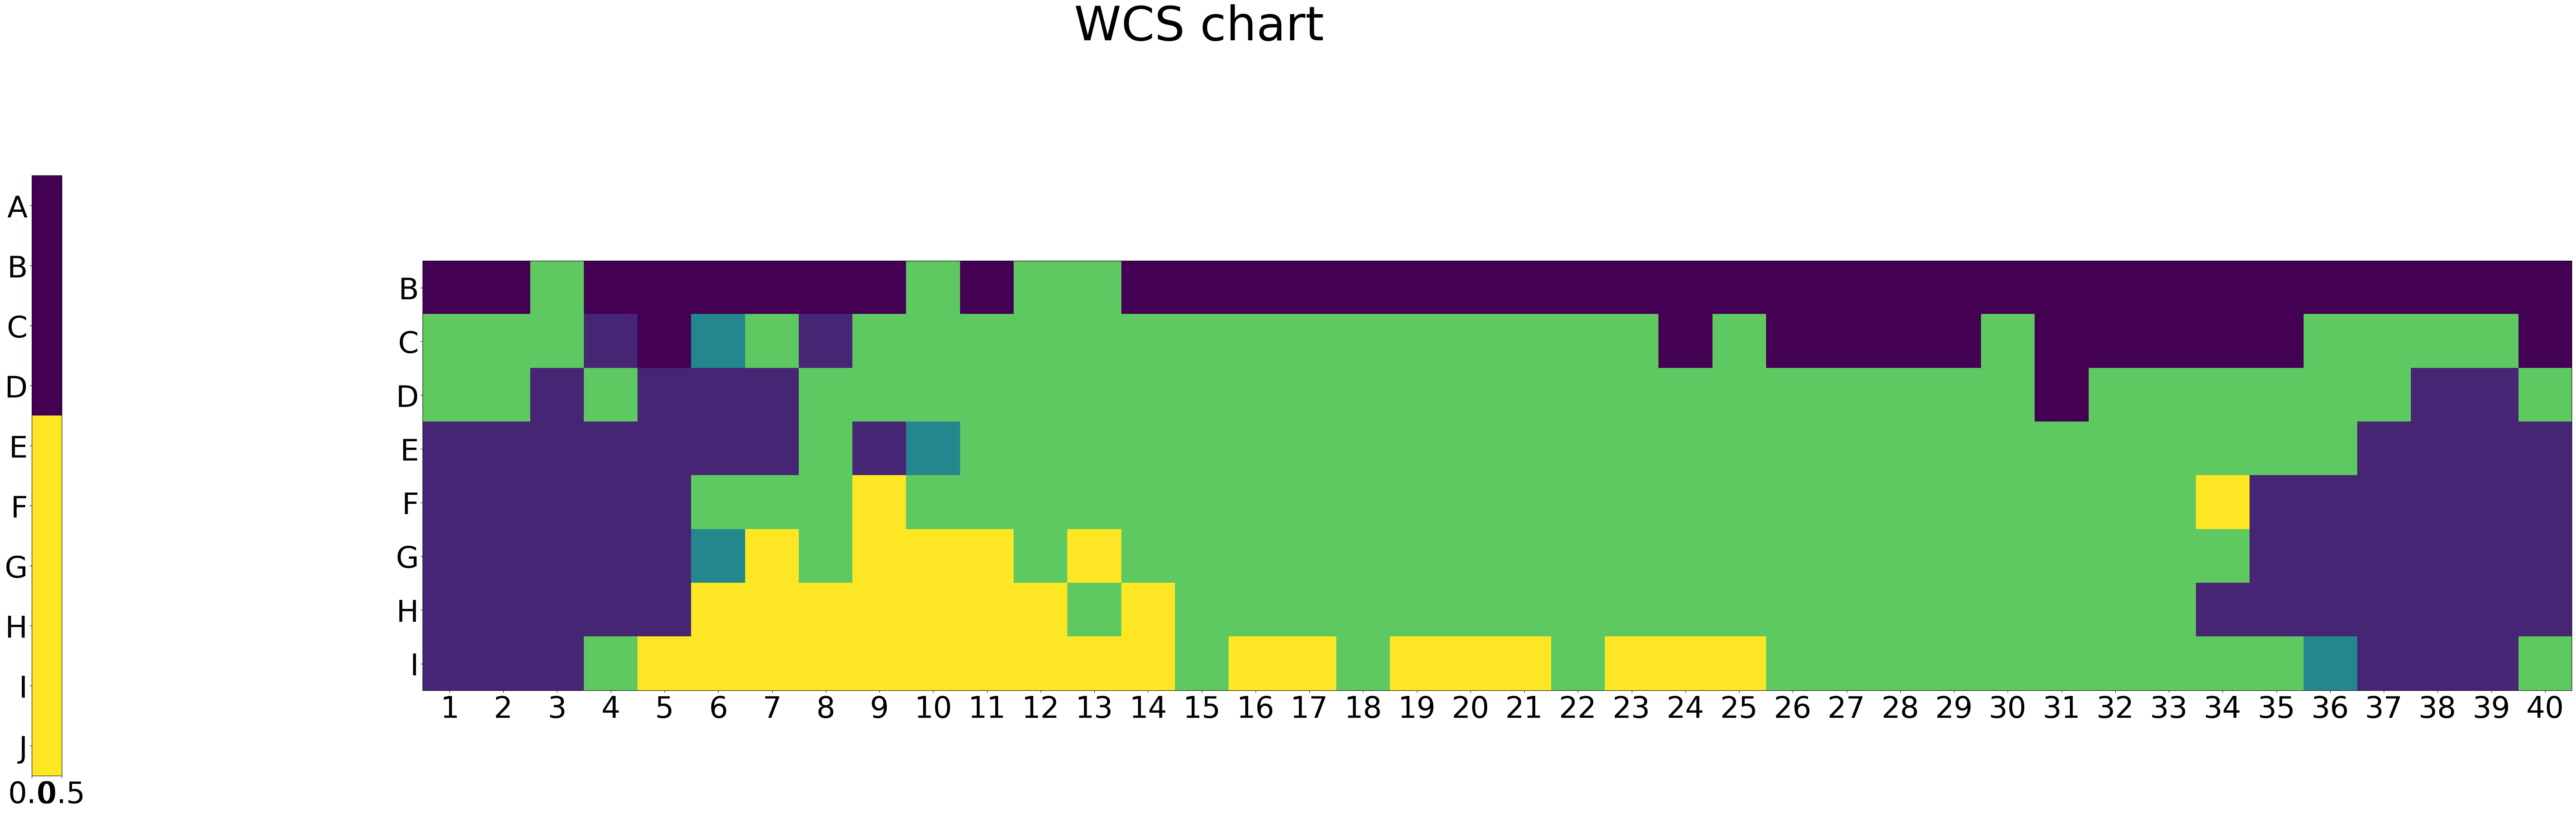

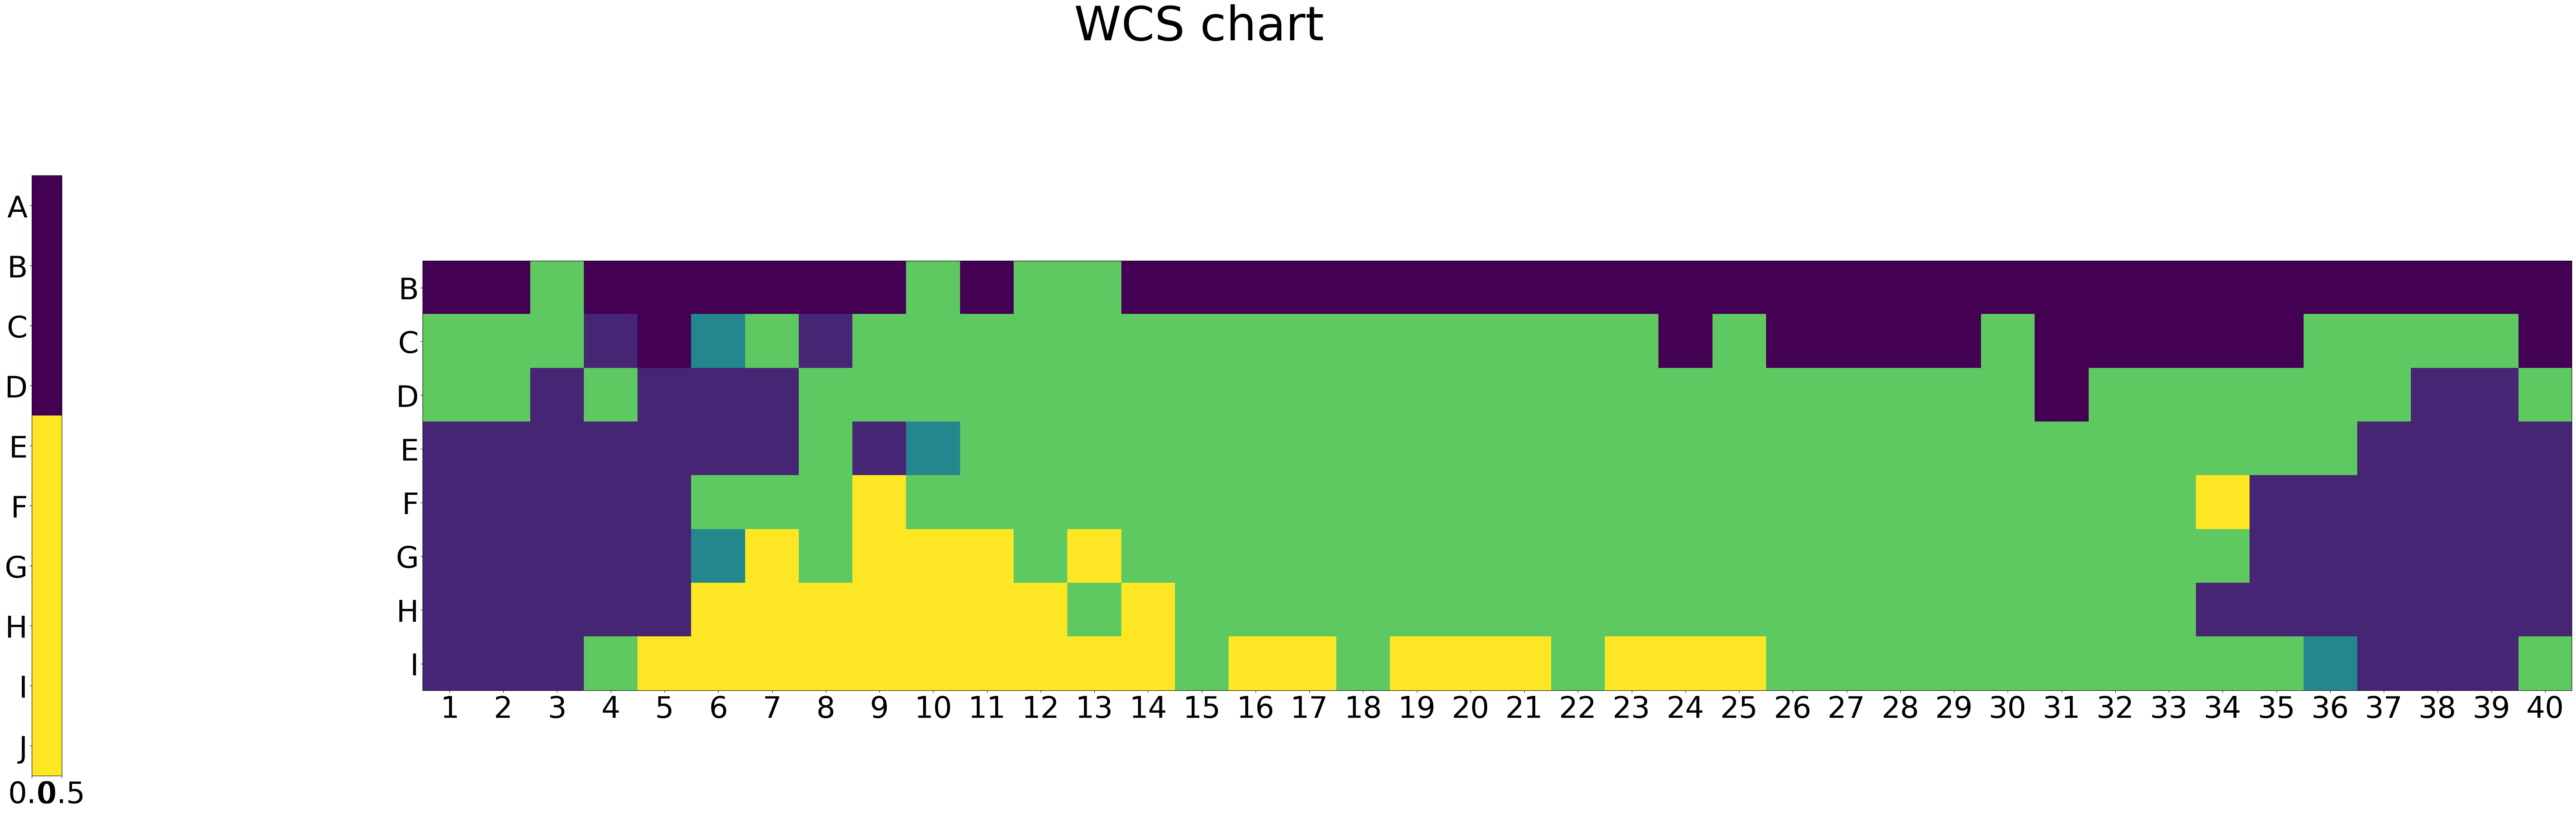

In [209]:
plotValues(encoded_terms)

**Note**: `plotValues()` is a generic function for visualizing various kinds of information on the chart, suited to needs.

Now you are in a position to start exploring this data set - enjoy!

## Our Analysis

### Empirical Color Foci

Our first goal is to reproduce the following diagram from Abbott, Griffiths, & Regier (2016) showing the empirical color foci from the WCS dataset.

![image.png](images/empirical-contours.png)

This graph shows the color chips that were most commonly identified as the focus of some color term across all languages. The clustering of the contours suggests a set of universal basic colors at each of the peaks in the contour plot.

Part of our evaluation of the prototype and exemplar models will be a qualitative comparison of their predicted color foci plots to this empirical one.

In [210]:
# fociData

In [211]:
overallFociCount = {}
for language in fociData:
    speakerData = fociData[language]
    for speaker in speakerData:
        colors = speakerData[speaker]
        for color in colors:
            colorFoci = colors[color]
            for focus in colorFoci:
                focusIndex = coordIndex[focus.replace(':', '')]
                if focusIndex in overallFociCount:
                    overallFociCount[focusIndex] += 1
                else:
                    overallFociCount[focusIndex] = 1


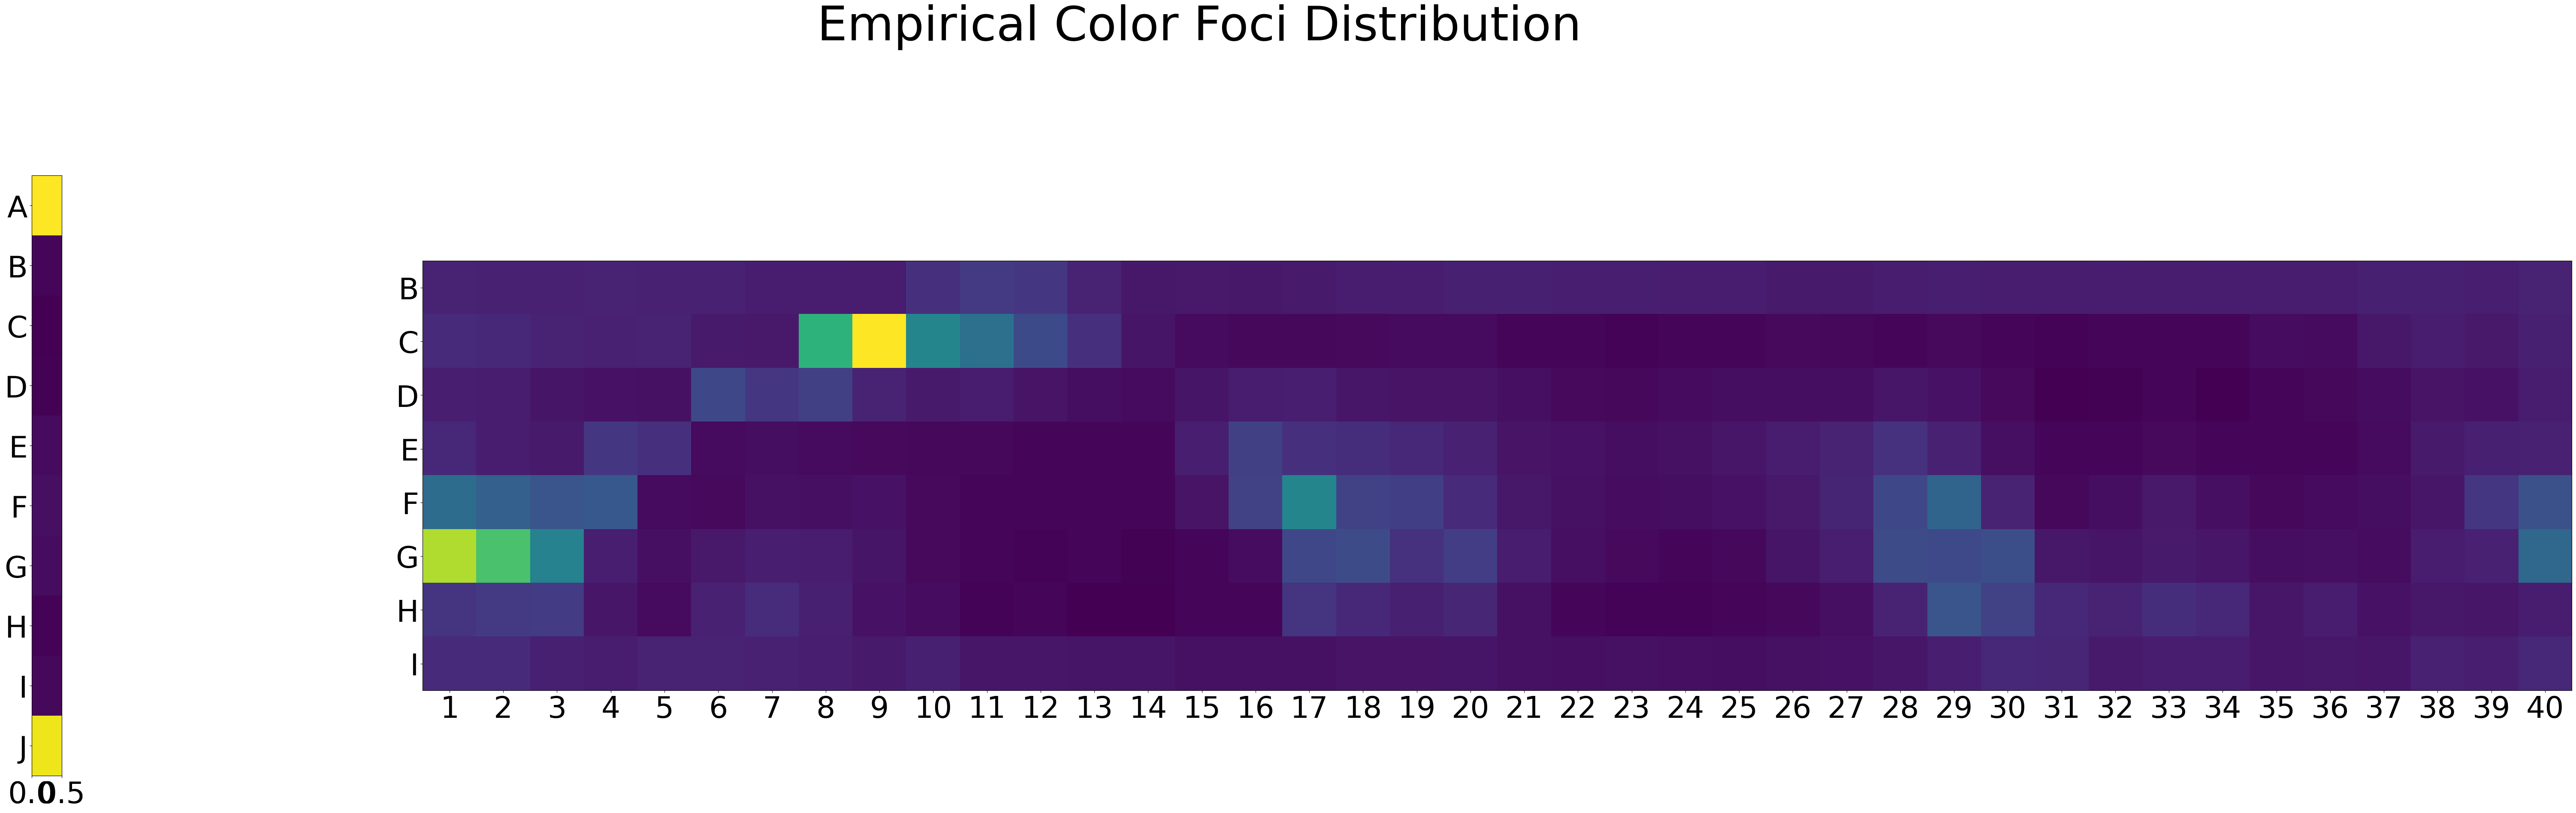

In [212]:
fig = plotValues(map_array_to(indexCoord, overallFociCount), title='Empirical Color Foci Distribution')

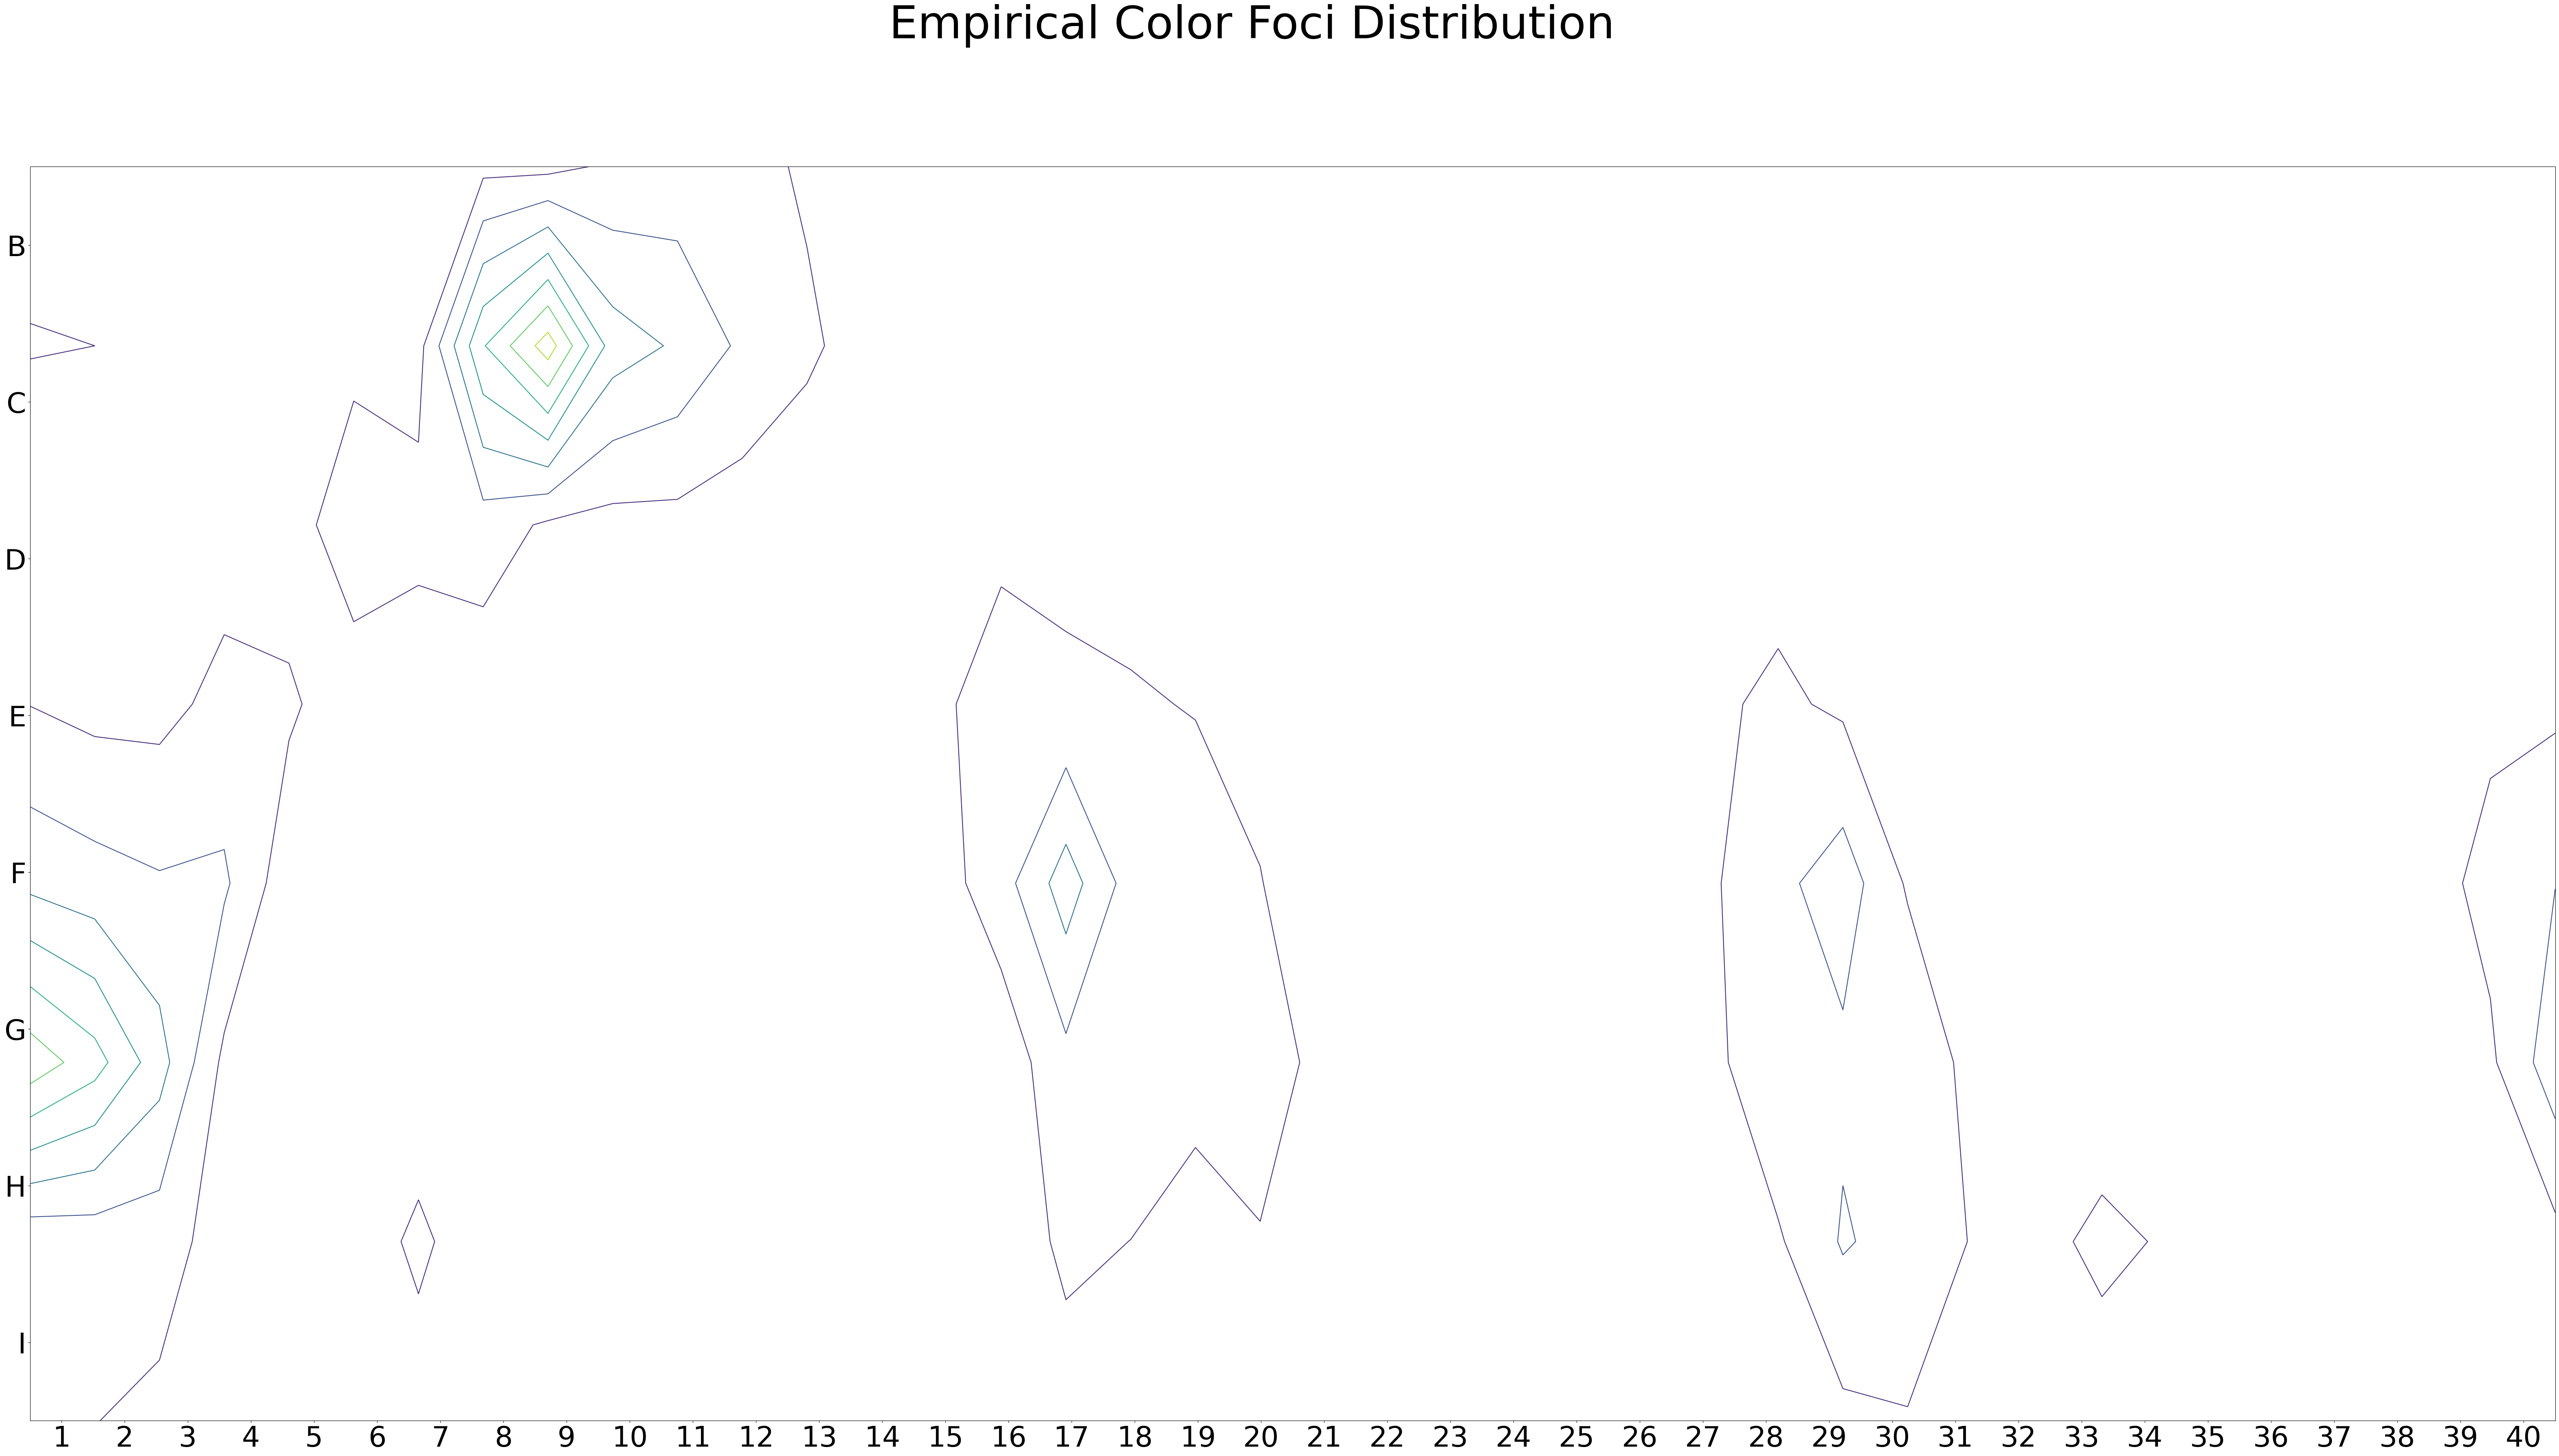

In [213]:
fig = plotValuesContour(map_array_to(indexCoord, overallFociCount), title='Empirical Color Foci Distribution')

### Prototype Model

In [214]:
def calculate_prototypes(speakerData, cielabCoord):
    # For each color category, calculate the centroid (average CIELAB coordinates)
    # Return a dictionary mapping each color category to its prototype

    color_term_accumulator = {}  # To accumulate CIELAB coordinates for each color term
    color_term_counts = {}  # To count occurrences of each color term

    for color_term in speakerData:
        fociLst = speakerData[color_term]
        for foci in fociLst:
            chip_index = coordIndex[foci.replace(":", "")]
            cielab_coord_str = cielabCoord[chip_index]
            
            # Convert the CIELAB coordinates from strings to floats
            cielab_coord = tuple(float(value) for value in cielab_coord_str)

            # Accumulate the CIELAB coordinates for each color term
            if color_term not in color_term_accumulator:
                color_term_accumulator[color_term] = np.zeros(len(cielab_coord))
                color_term_counts[color_term] = 0
            color_term_accumulator[color_term] += np.array(cielab_coord)
            color_term_counts[color_term] += 1

    # Compute the centroid of CIELAB coordinates for each color term
    color_prototypes = {}
    for color_term in color_term_accumulator:
        color_prototypes[color_term] = color_term_accumulator[color_term] / color_term_counts[color_term]

    return color_prototypes


In [215]:
speaker_prototypes = {}
for language in fociData:
    speakersData = fociData[language]
    for speaker in speakersData:
        speakerData = speakersData[speaker]
        speaker_prototypes[(language, speaker)] = calculate_prototypes(speakerData, cielabCoord)

In [216]:
# basically replicating fociData to get prototype model's predicted foci

def compute_similarity(prototype, cielab_coords, c=0.001):
    # Vectorized computation of Euclidean distance between prototype and all CIELAB coordinates
    distances = np.linalg.norm(cielab_coords - prototype, axis=1)

    # Calculate the similarity scores
    similarities = np.exp(-c * distances**2)

    return similarities

cielab_array = np.array([tuple(map(float, coords)) for coords in cielabCoord.values()])
# cielab_array = np.array([list(map(float, v)) for v in cielabCoord.values()])
# print(cielab_array.shape)
# print(cielab_array)
# print(cielabCoord.values())

# foci(index) : count
predicted = {}
for language in fociData:
    languageData = fociData[language]
    for speaker in languageData:
        speakerData = languageData[speaker]

        for colour in speakerData:
            fociInfo = speakerData[colour]
            n = len(fociInfo)

            # Get the prototype for this color
            prototype = np.array(speaker_prototypes[(language, speaker)][colour])
            # print(prototype.shape)

            # Compute similarities to all color chips (vectorized operation)
            similarities = compute_similarity(prototype, cielab_array)
            # print(similarities.shape)
            # print(similarities)
            # print("######################")
            # break

            # Get indices of the top n most similar chips
            # more similar = larger score
            top_n_indices = np.argsort(-similarities)[:n]

            # Update the predicted count for each of the top n chips
            for idx in top_n_indices:
                chip_index = list(cielabCoord.keys())[idx]
                if chip_index not in predicted:
                    predicted[chip_index] = 0
                predicted[chip_index] += 1


In [217]:
sum(sum(sum(len(fociInfo) for fociInfo in speakerData.values()) for speakerData in fociData.values()) for fociData in fociData.values())

30991

In [218]:
print(predicted)

{141: 2405, 146: 99, 258: 87, 193: 58, 12: 272, 49: 51, 89: 2321, 202: 296, 298: 292, 148: 548, 321: 266, 245: 352, 288: 213, 98: 579, 84: 82, 56: 81, 201: 94, 217: 95, 237: 85, 256: 104, 10: 65, 43: 68, 17: 88, 58: 42, 287: 63, 330: 82, 108: 86, 219: 84, 221: 83, 27: 94, 125: 89, 96: 314, 214: 91, 91: 30, 311: 69, 35: 51, 278: 57, 318: 41, 151: 85, 34: 161, 169: 91, 190: 61, 160: 58, 285: 47, 106: 95, 164: 218, 265: 119, 71: 101, 121: 115, 176: 97, 188: 61, 15: 30, 140: 92, 213: 17, 167: 20, 102: 14, 118: 57, 235: 174, 324: 100, 302: 96, 230: 113, 290: 92, 129: 121, 44: 127, 74: 31, 116: 30, 264: 31, 175: 34, 197: 25, 308: 29, 273: 22, 80: 178, 64: 164, 270: 58, 212: 153, 261: 59, 187: 111, 48: 51, 181: 46, 291: 74, 136: 60, 189: 25, 303: 20, 322: 31, 254: 16, 138: 50, 6: 65, 66: 73, 92: 79, 220: 28, 109: 48, 224: 93, 314: 105, 319: 92, 252: 114, 241: 83, 239: 50, 86: 34, 28: 77, 126: 72, 292: 81, 63: 78, 78: 27, 21: 86, 173: 91, 247: 39, 52: 61, 5: 40, 180: 103, 110: 145, 218: 34, 30

In [219]:
print(len(overallFociCount))
print(len(predicted))

330
330


In [220]:
sum(overallFociCount.values()), sum(predicted.values())

(30991, 30991)

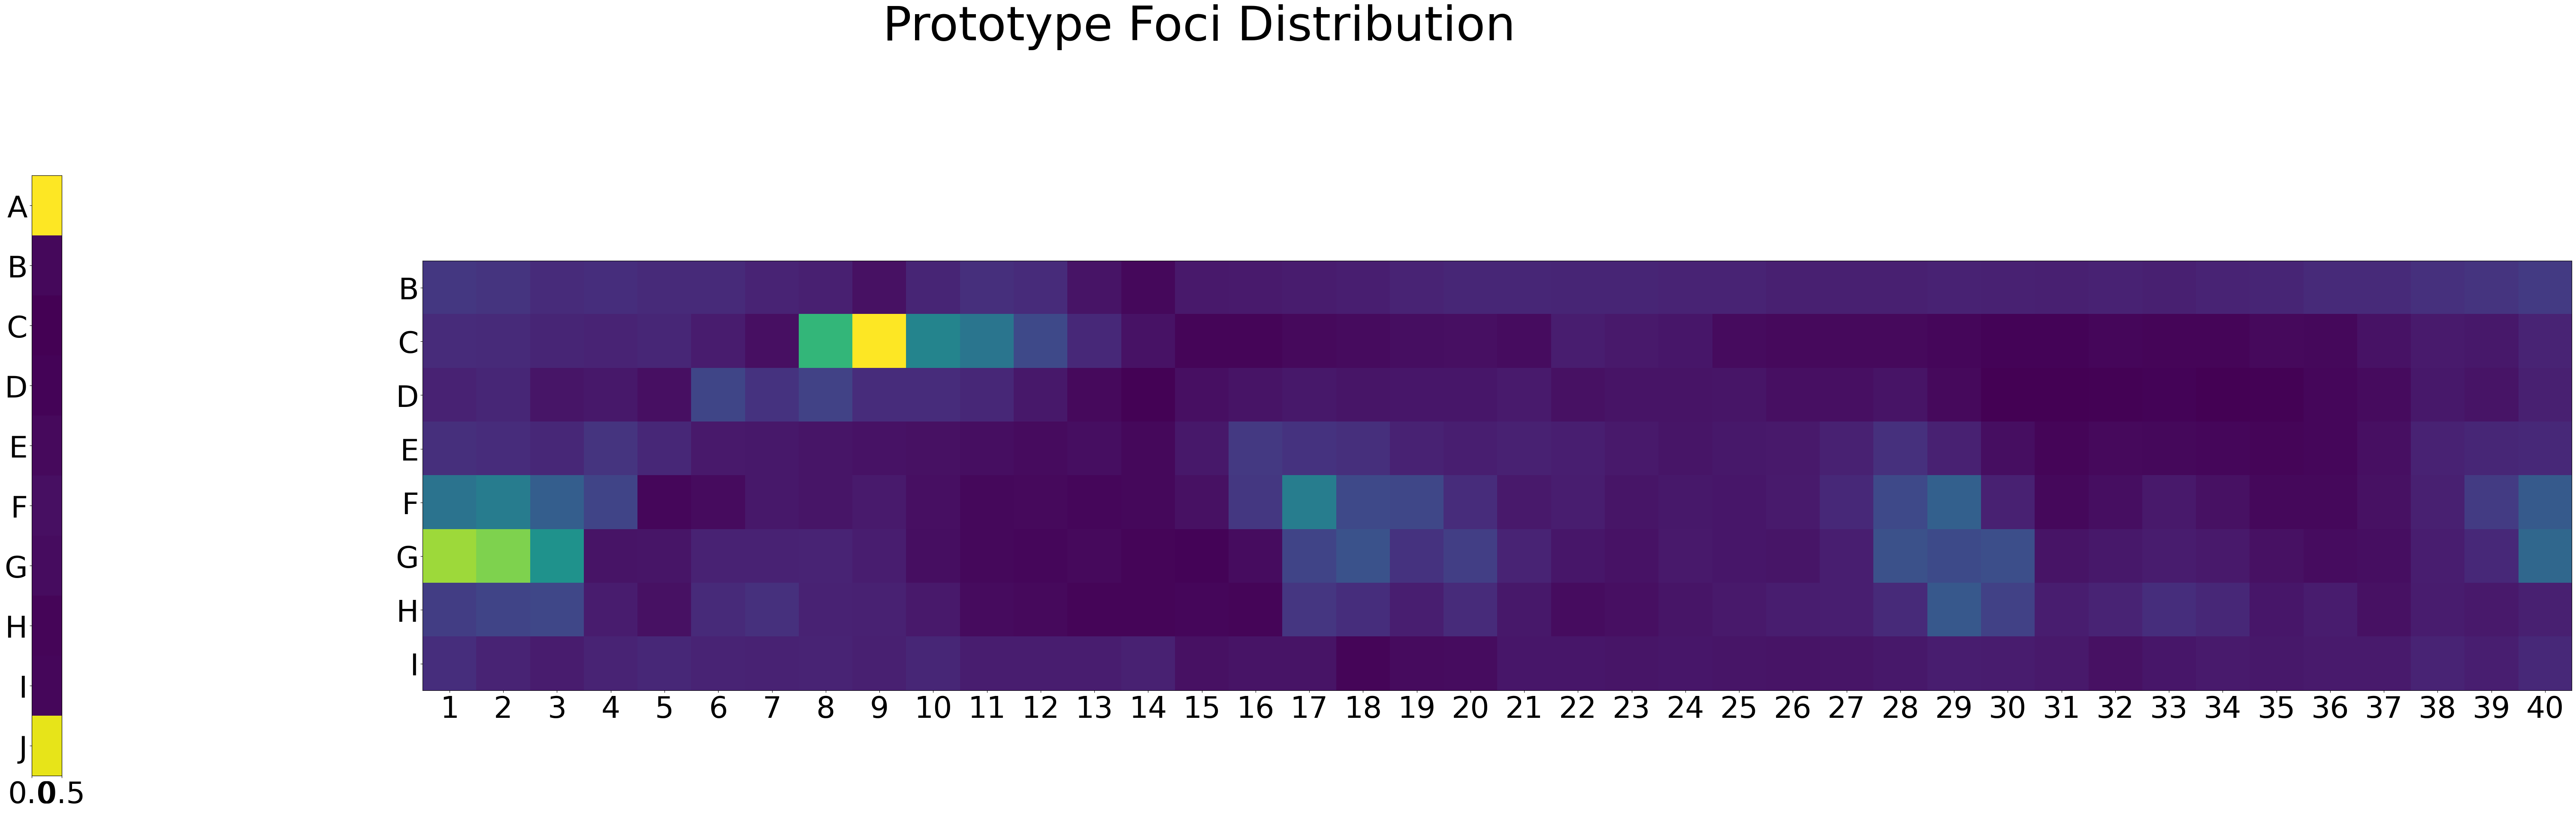

In [221]:
fig = plotValues(map_array_to(indexCoord, predicted), title='Prototype Foci Distribution')

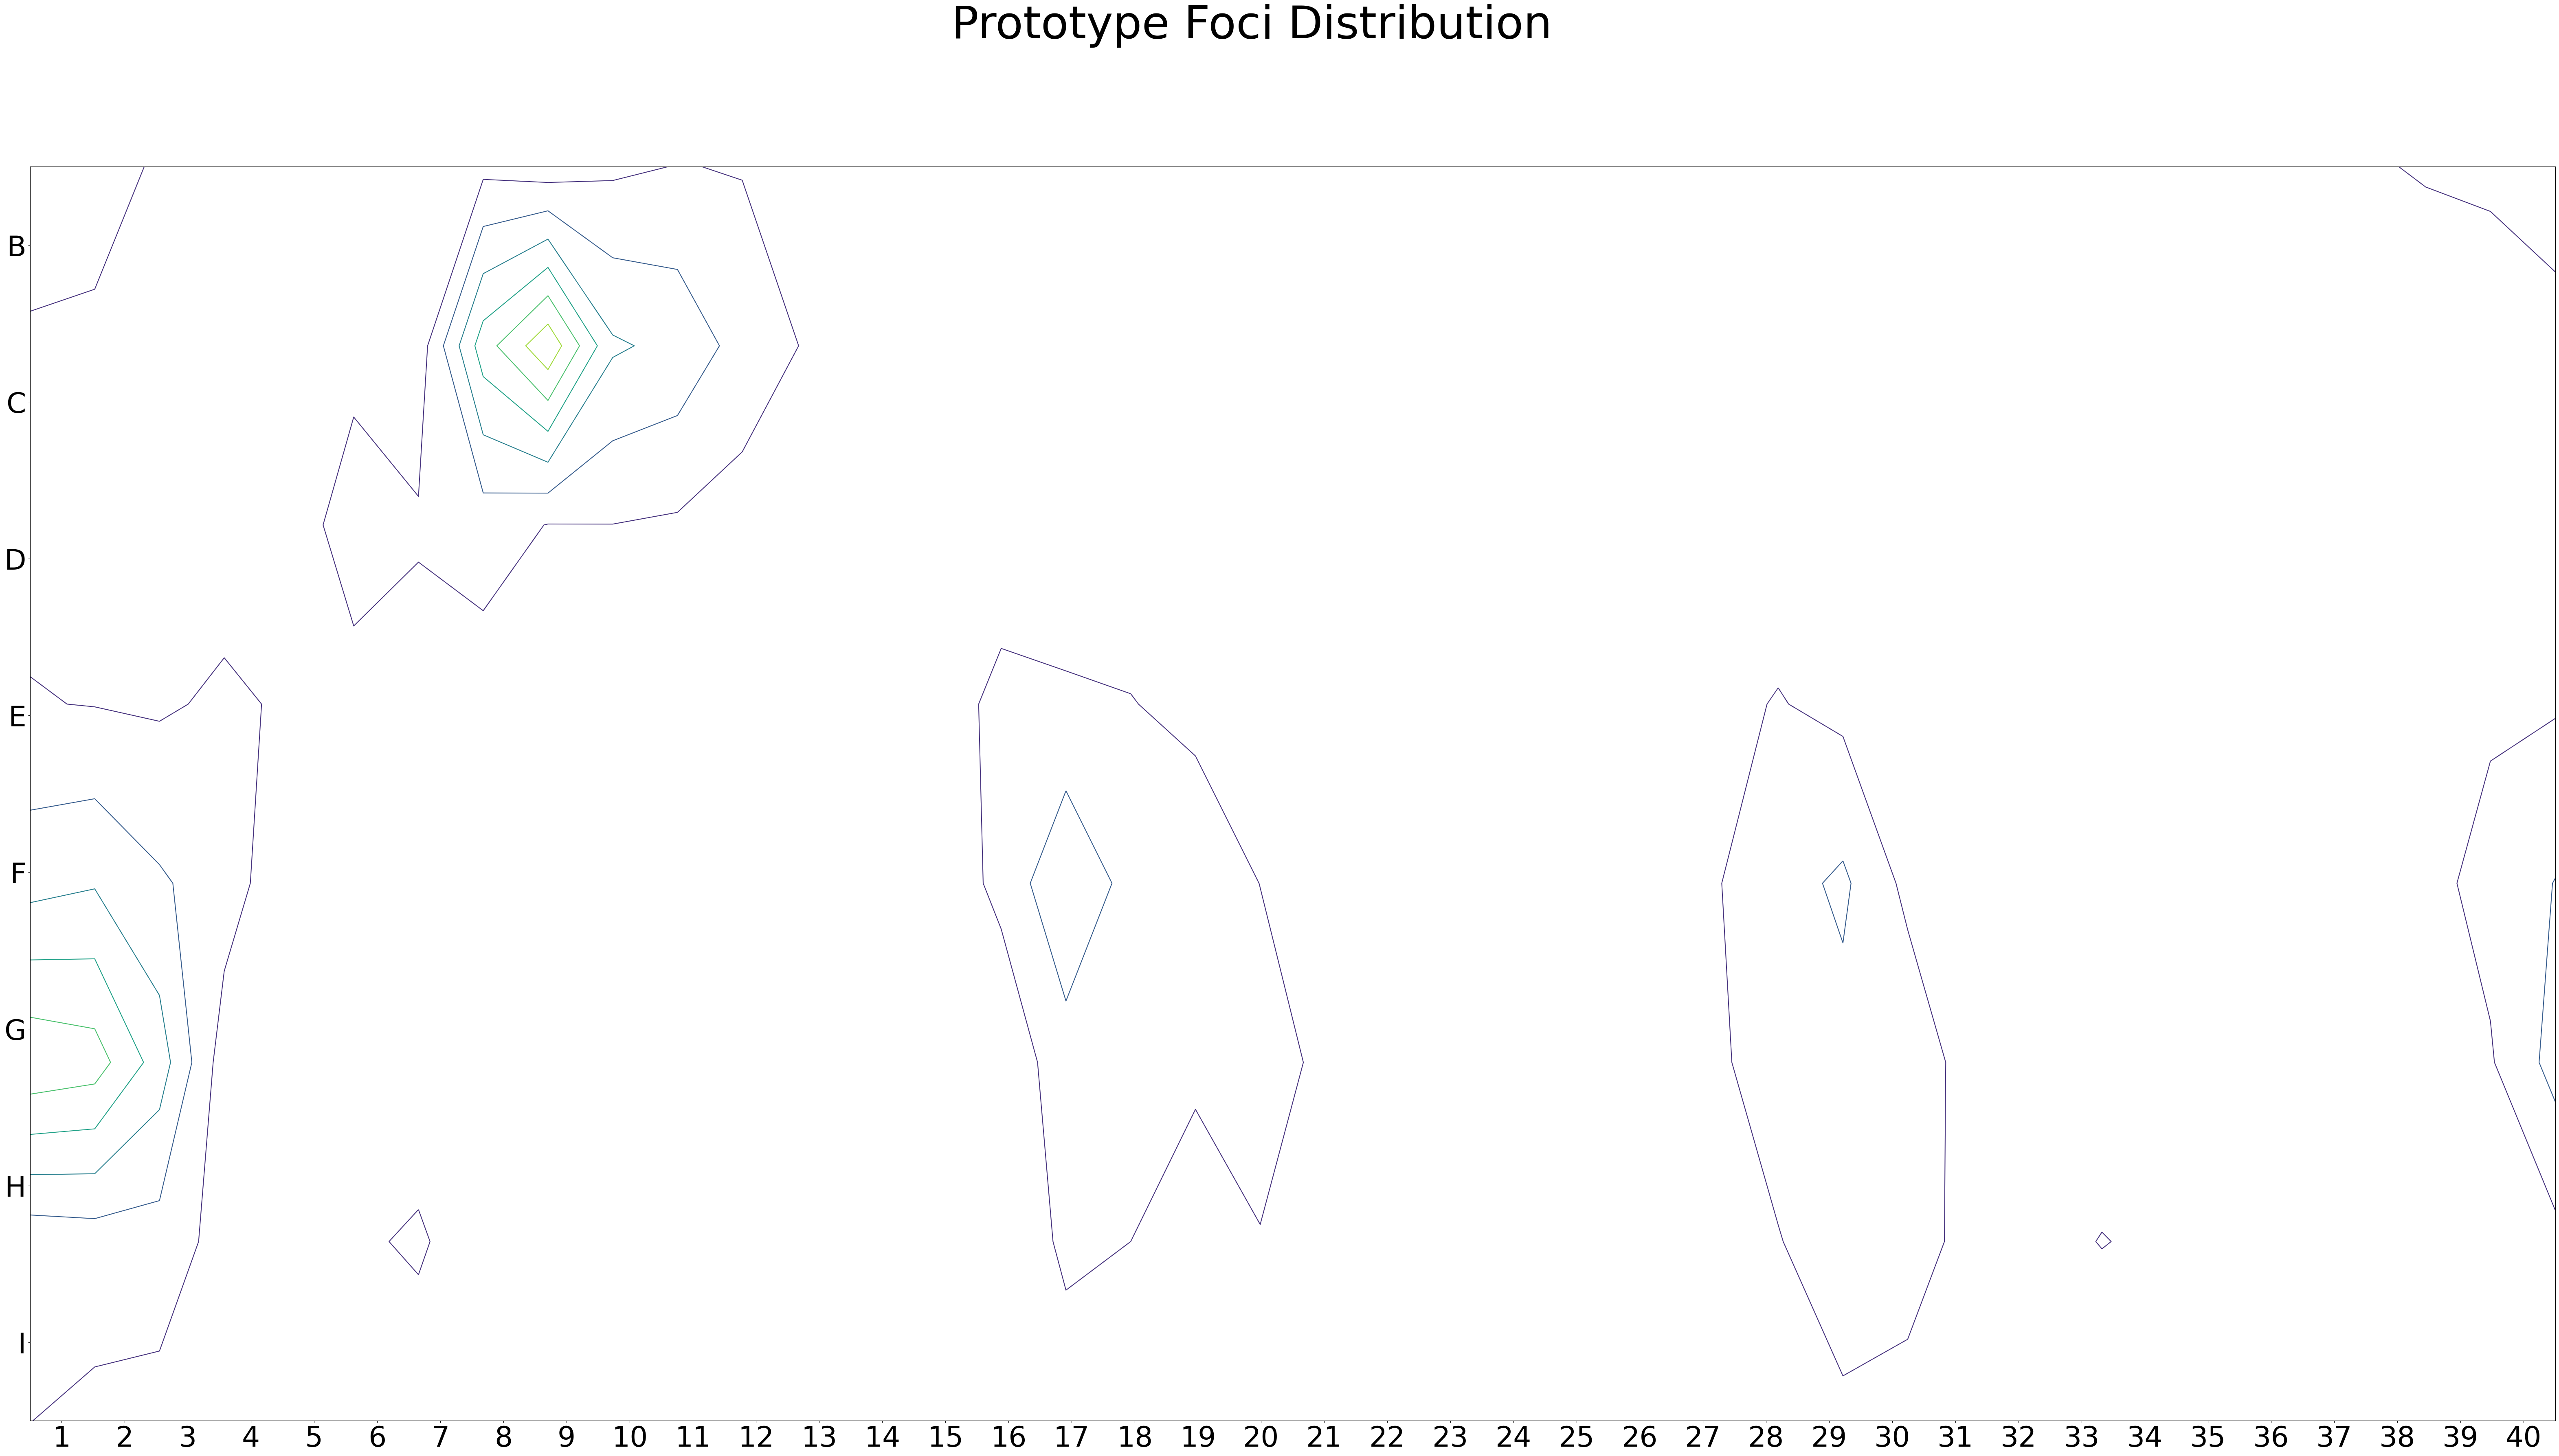

In [222]:
fig = plotValuesContour(map_array_to(indexCoord, predicted), title='Prototype Foci Distribution')

### Quantitative Analysis

In [223]:
def create_histogram(distribution, num_chips=330):
    histogram = np.zeros(num_chips)
    for chip_index in distribution:
        histogram[int(chip_index) - 1] = distribution[int(chip_index)]  # Assuming chip_index starts from 1
    return histogram

# Assuming we have 330 chips
hist_prototype = create_histogram(predicted, 330)
hist_wcs_focus = create_histogram(overallFociCount, 330)

In [224]:
def qf_distance(H1, H2, M):
    diff = H1 - H2
    return np.sqrt(diff.T @ M @ diff)

In [225]:
def calculate_similarity_matrix(cielab_coords, c=0.001):
    num_chips = len(cielab_coords)
    M = np.zeros((num_chips, num_chips))

    for i in range(num_chips):
        for j in range(num_chips):
            # Calculate Euclidean distance between chip i and chip j
            distance = np.linalg.norm(cielab_coords[i] - cielab_coords[j])
            # Calculate similarity based on the distance
            M[i, j] = np.exp(-c * distance**2)

    return M

In [226]:
cielab_array = np.array([tuple(map(float, coords)) for coords in cielabCoord.values()])

M = calculate_similarity_matrix(cielab_array)

In [227]:
M.shape

(330, 330)

In [228]:
qf_prototype = qf_distance(hist_wcs_focus, hist_prototype, M)

In [229]:
qf_prototype

237.5128110087758